In [2]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [4]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [5]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [6]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [7]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [8]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [9]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [10]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


## Gather properties

In [11]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [12]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [13]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = None
x_test_extra = x_features_extra[idx_test]

## Mstellar

In [14]:
y_label_name = 'm_stellar'

In [21]:
#fit_tag = f'_{y_label_name}_nn'
#fit_tag = f'_{y_label_name}_nn_epochs500_lr0.0001_hs64'
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [22]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [23]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [24]:
import torch
model_checkpoint = torch.load(fn_model)

In [25]:
model_checkpoint

{'input_size': 570,
 'hidden_size': 128,
 'output_size': 1,
 'model_state_dict': OrderedDict([('lin1.weight',
               tensor([[ 3.5595e-02,  3.7873e-02,  2.1380e-02,  ...,  3.2665e-02,
                        -4.7106e-02, -6.3242e-02],
                       [ 3.3187e-02, -1.2478e-01, -8.6374e-02,  ...,  7.4749e-02,
                         3.4614e-02, -3.0653e-02],
                       [ 1.6798e-01,  8.1461e-02,  9.6159e-02,  ..., -1.9207e-02,
                         7.8530e-02,  9.8650e-02],
                       ...,
                       [-2.6064e-02,  1.2191e-02, -1.1599e-01,  ..., -6.1002e-05,
                         6.9396e-02, -7.9421e-03],
                       [-1.2931e-01, -1.5068e-01, -9.7189e-02,  ...,  4.0277e-02,
                        -6.9938e-02,  1.0083e-02],
                       [-1.0220e-01, -8.3633e-02,  1.8706e-02,  ..., -3.6881e-02,
                        -6.5009e-02, -2.7958e-02]], dtype=torch.float64)),
              ('lin1.bias',
            

100.87310458088572


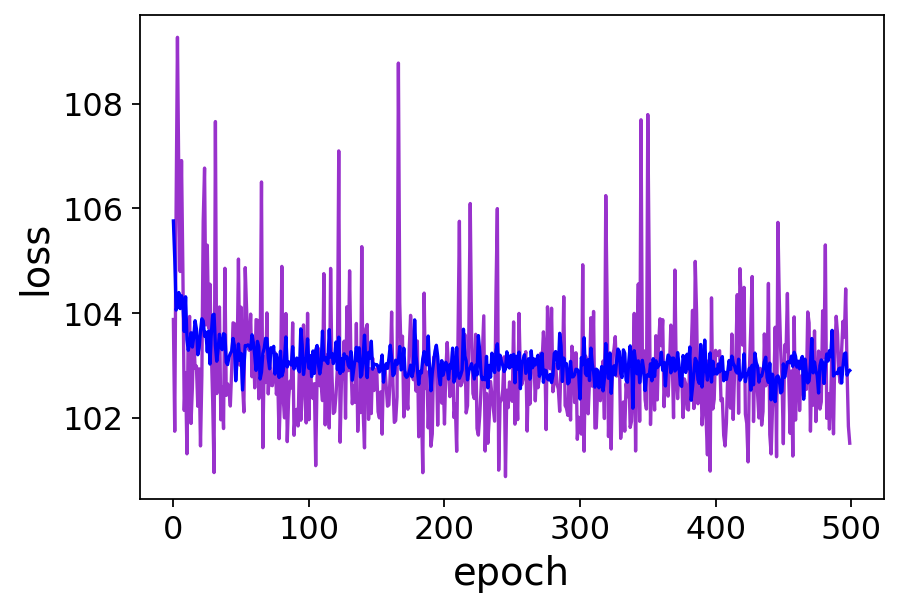

In [28]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
#plt.ylim(0, nnfitter.loss_train[2])
print(np.min(nnfitter.loss_valid))

In [29]:
plt.plot(nnfitter.loss, color='darkorchid')
plt.xlabel('epoch')
plt.ylabel('loss')

AttributeError: 'NNFitter' object has no attribute 'loss'

In [30]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

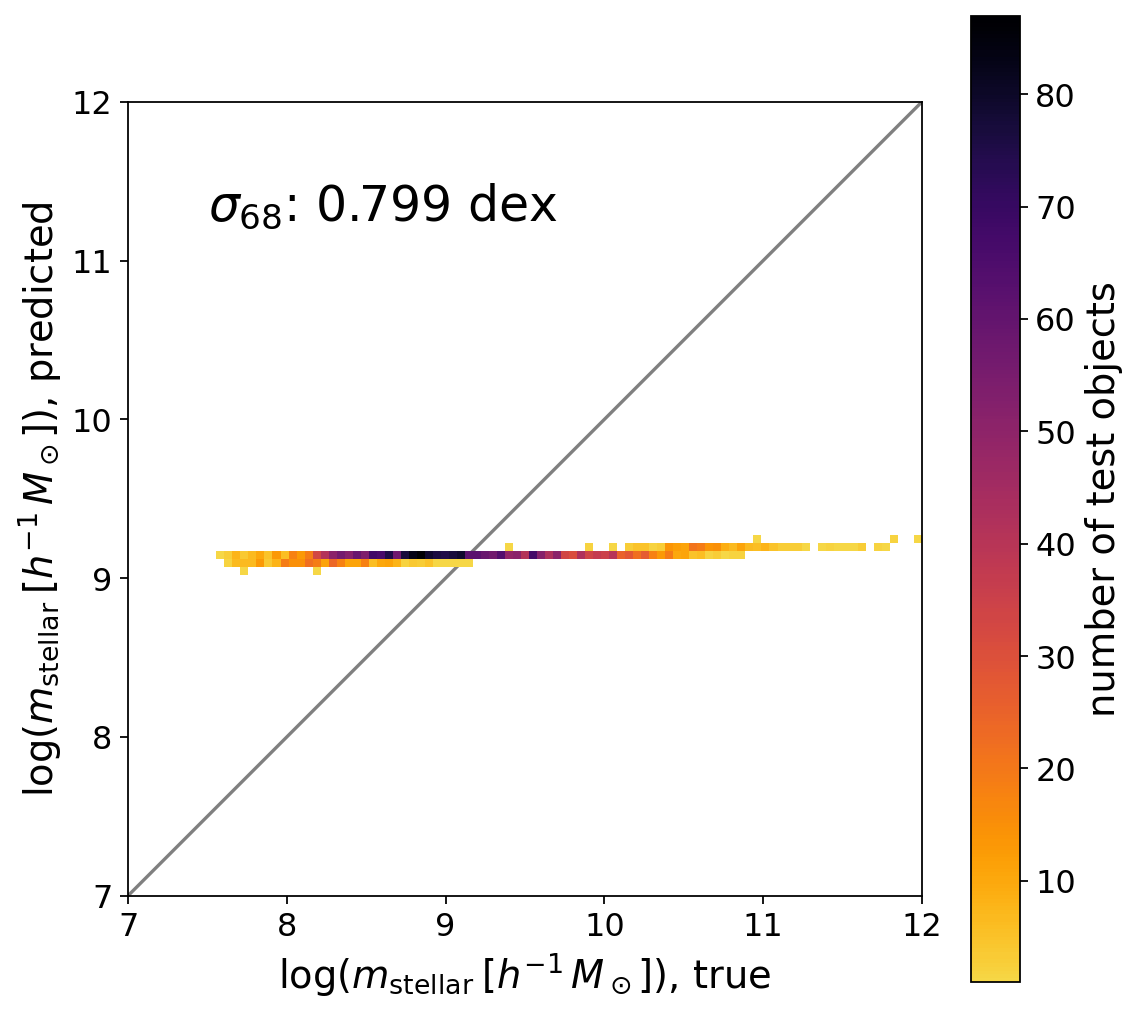

In [31]:
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(7,12),  y_lim=(7,12))

In [34]:
def plot_error_fig(y_true, y_pred):
    plt.figure()
    bins = np.linspace(np.min(y_true), np.max(y_true), 14)
    delta_y = y_pred - y_true
    delta_y_binned = np.empty(len(bins)-1)
    for i in range(len(bins)-1):
        idx_inbin = (y_true >= bins[i]) & (y_true < bins[i+1])
        delta_y_binned[i] = np.median(delta_y[idx_inbin])
    bins_avg = 0.5*(bins[1:] + bins[:-1])
    plt.plot(bins_avg, delta_y_binned)

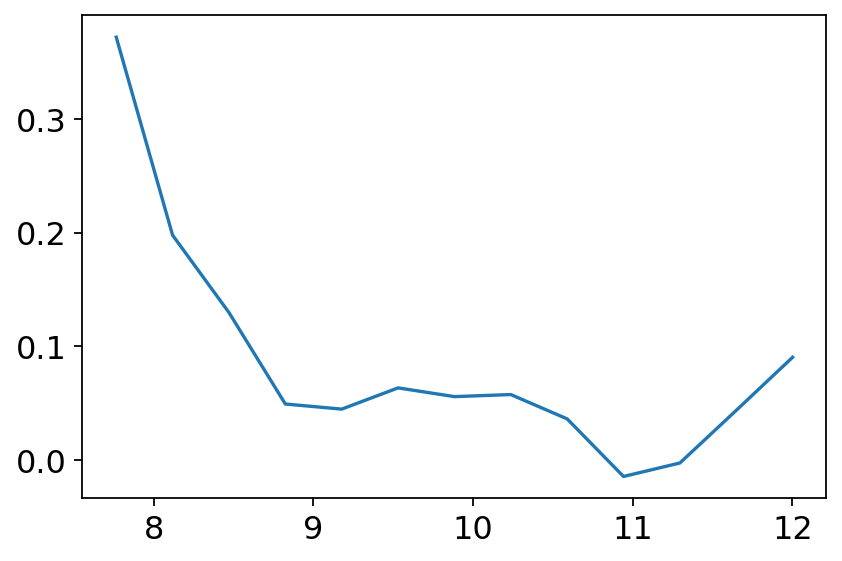

In [35]:
plot_error_fig(y_test_mult, y_pred_mult)

# sSFR1

In [324]:
y_label_name = 'ssfr1'

In [325]:
fit_tag = f'_{y_label_name}_nn'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
print(fn_model)

../models/models_TNG100-1/model_TNG100-1_ssfr1_nn.pt


In [326]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [327]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

(-1.0, 0.06266577252010719)

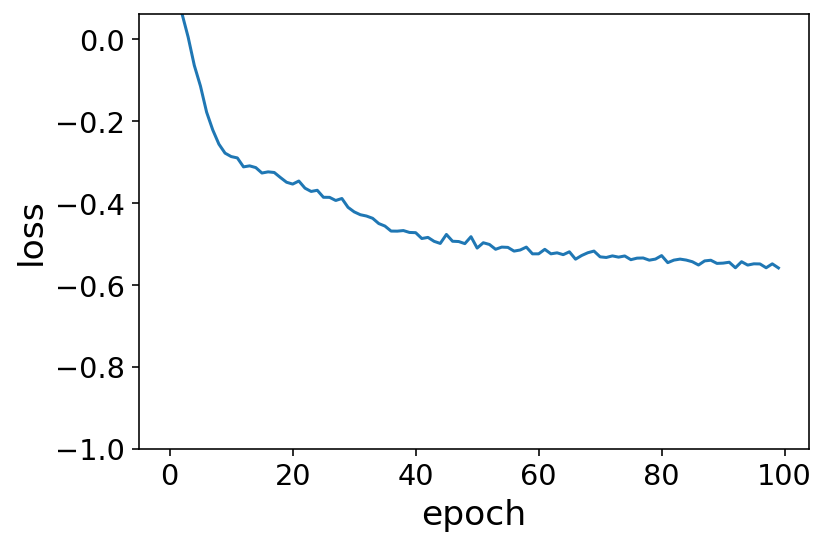

In [329]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(-1, nnfitter.loss[2])

In [331]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:322: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  m_stellar_Msun_arr = (m_stellar_arr*mass_multiplier)/h


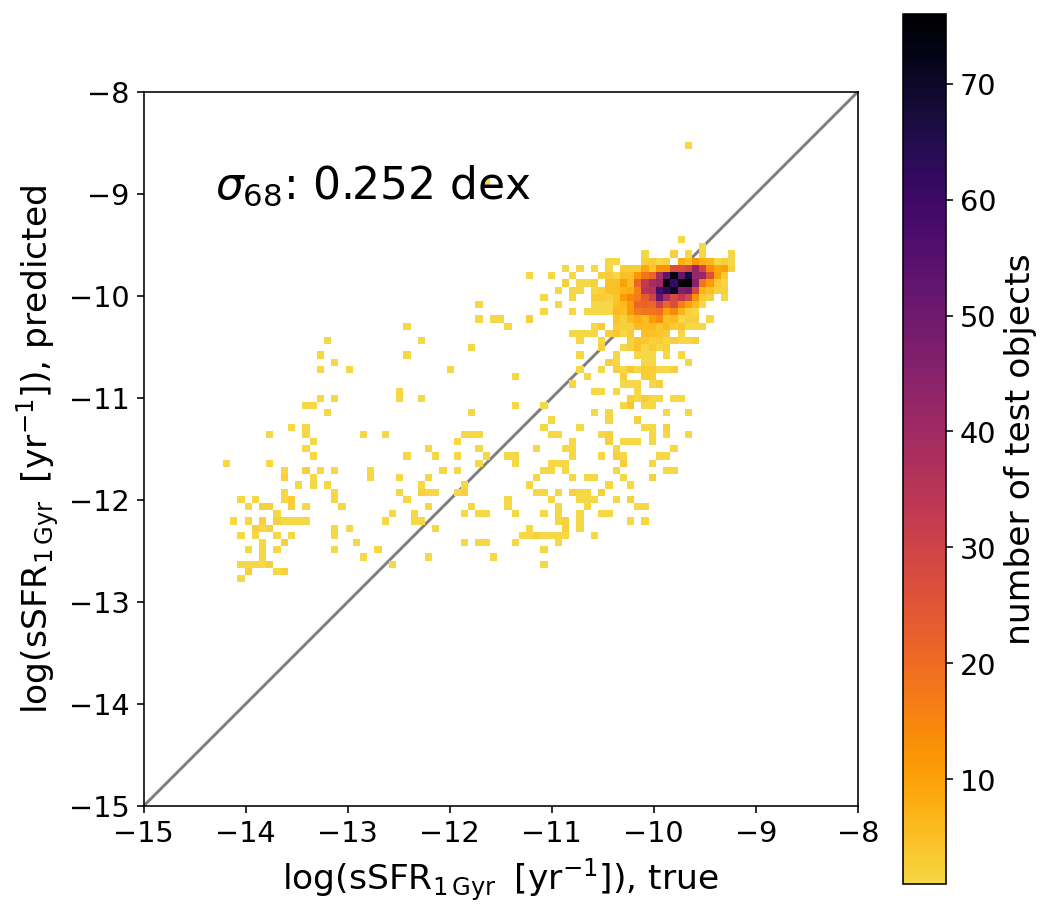

In [332]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(-15,-8),  y_lim=(-15,-8))

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:322: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  m_stellar_Msun_arr = (m_stellar_arr*mass_multiplier)/h


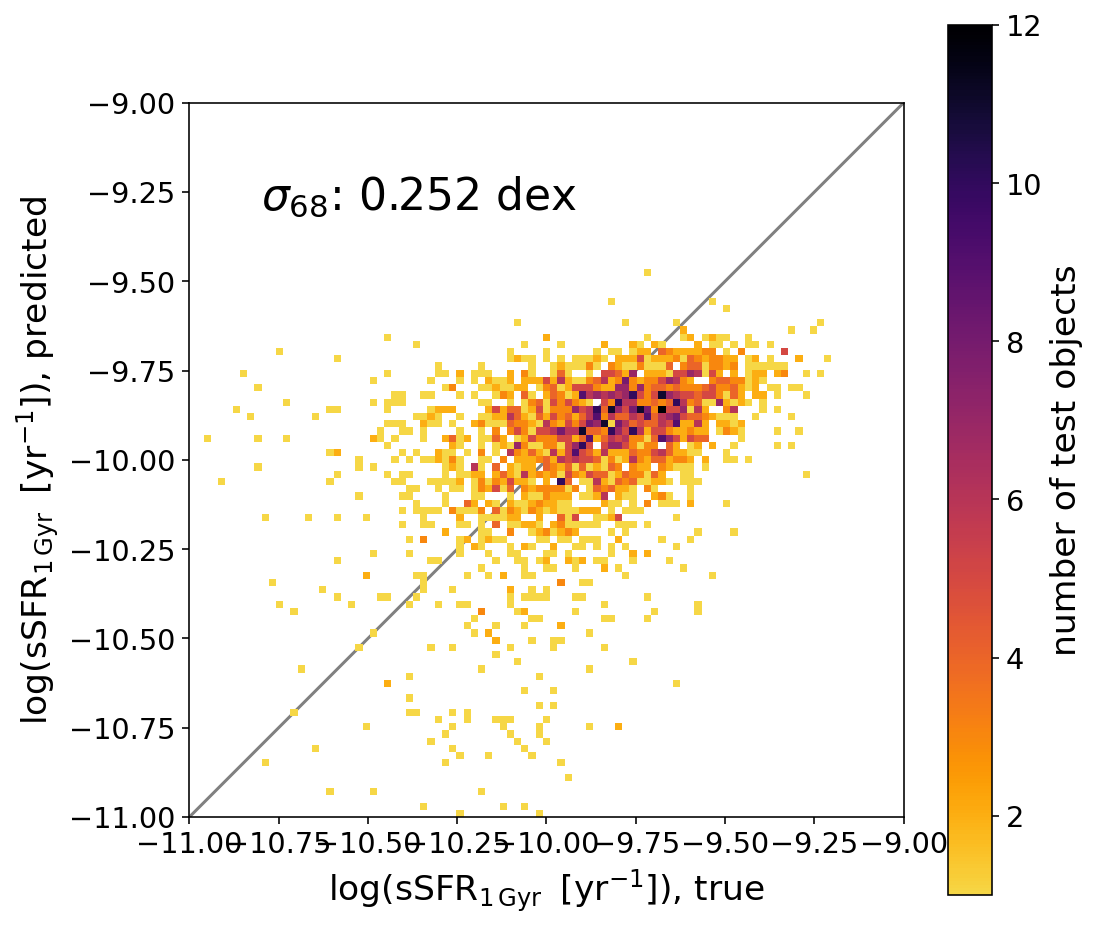

In [333]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(-11,-9),  y_lim=(-11,-9))

## Rstellar

In [70]:
y_label_name = 'r_stellar'

In [71]:
fit_tag = f'_{y_label_name}_nn'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [72]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [76]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

Text(0, 0.5, 'loss')

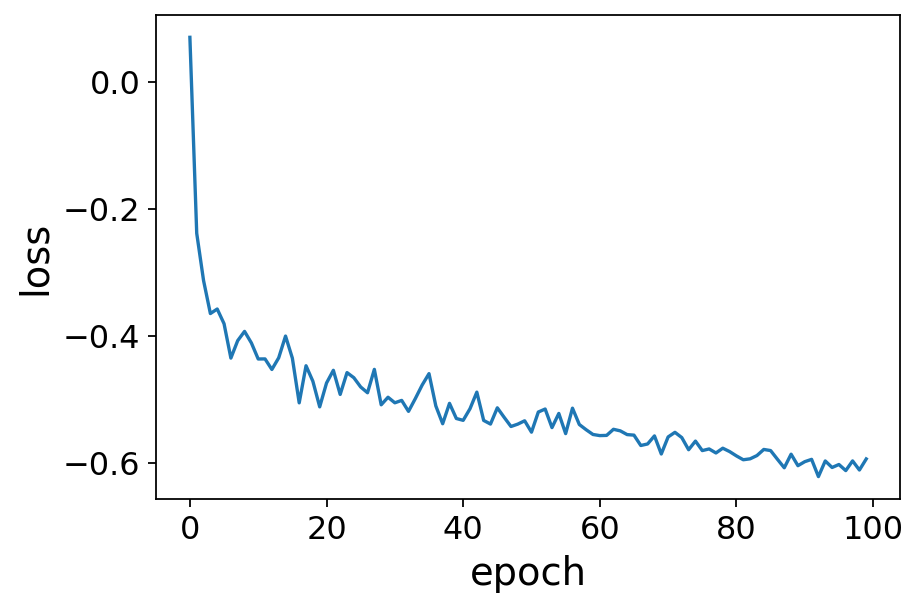

In [81]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])

In [78]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:314: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)


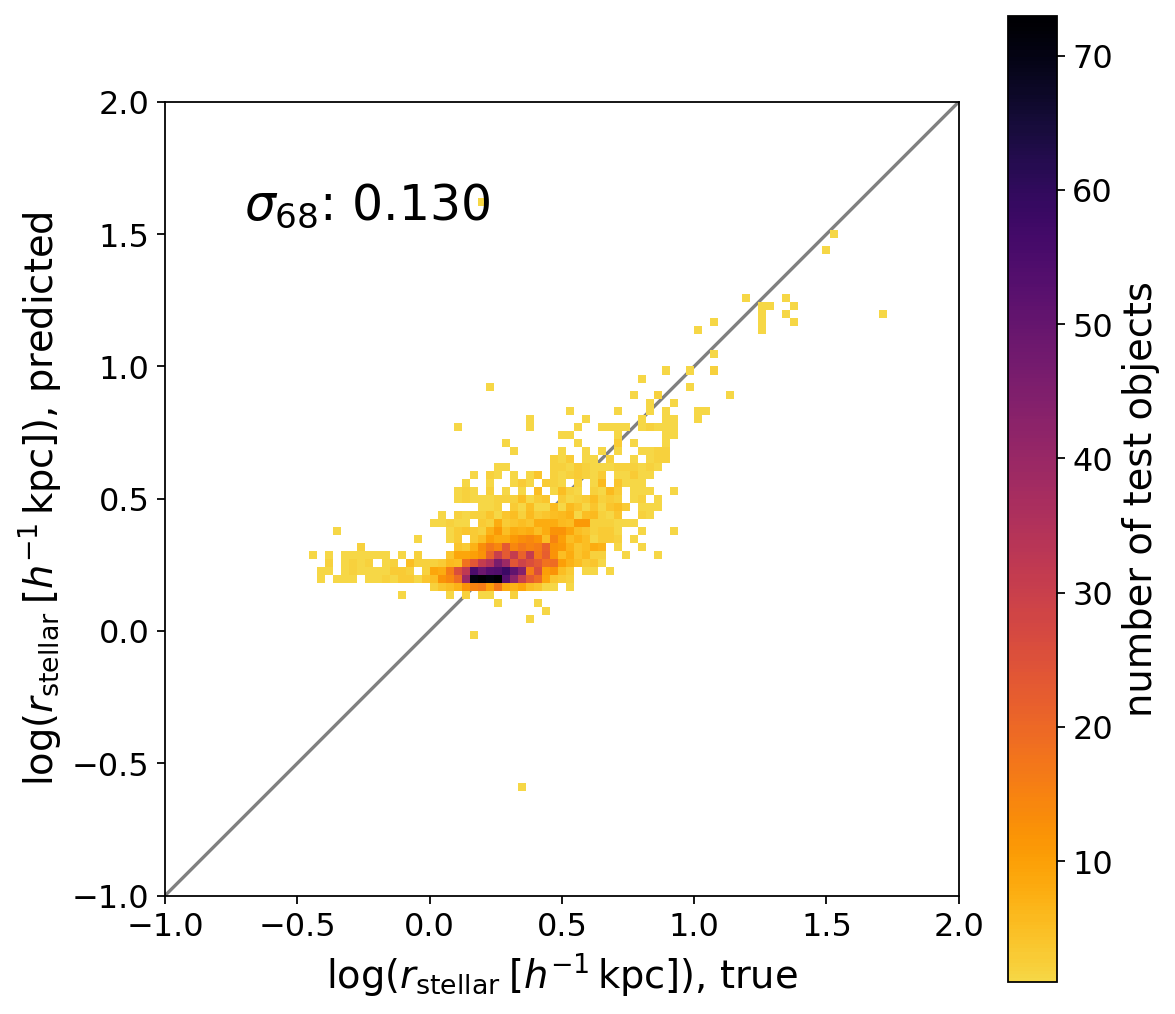

In [80]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(-1,2),  y_lim=(-1,2))

# MAH

## a_mfrac_0.5

In [54]:
y_label_name = 'a_mfrac_0.5'

In [55]:
#fit_tag = f'_{y_label_name}_nn_epochs1000_lr1e-3'
#fit_tag = f'_{y_label_name}_nn_epochs2500'
fit_tag = f'_{y_label_name}_nn_epochs2000'
#fit_tag = f'_{y_label_name}_nn'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [56]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [57]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

Text(0, 0.5, 'loss')

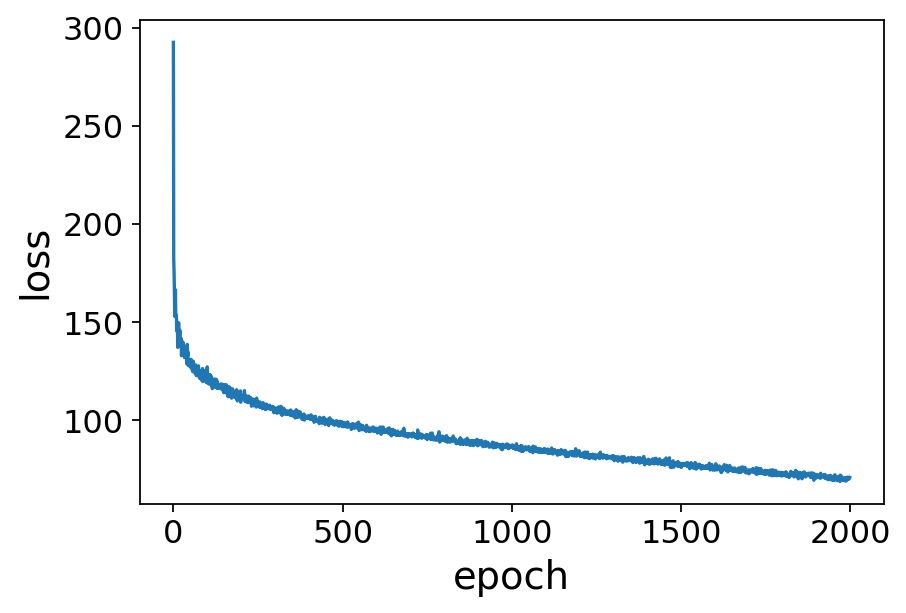

In [61]:
plt.plot(nnfitter.loss)

# plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
# plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss_train[2])
#print(np.min(nnfitter.loss_valid))
#plt.ylim(400, 500)

In [62]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:322: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


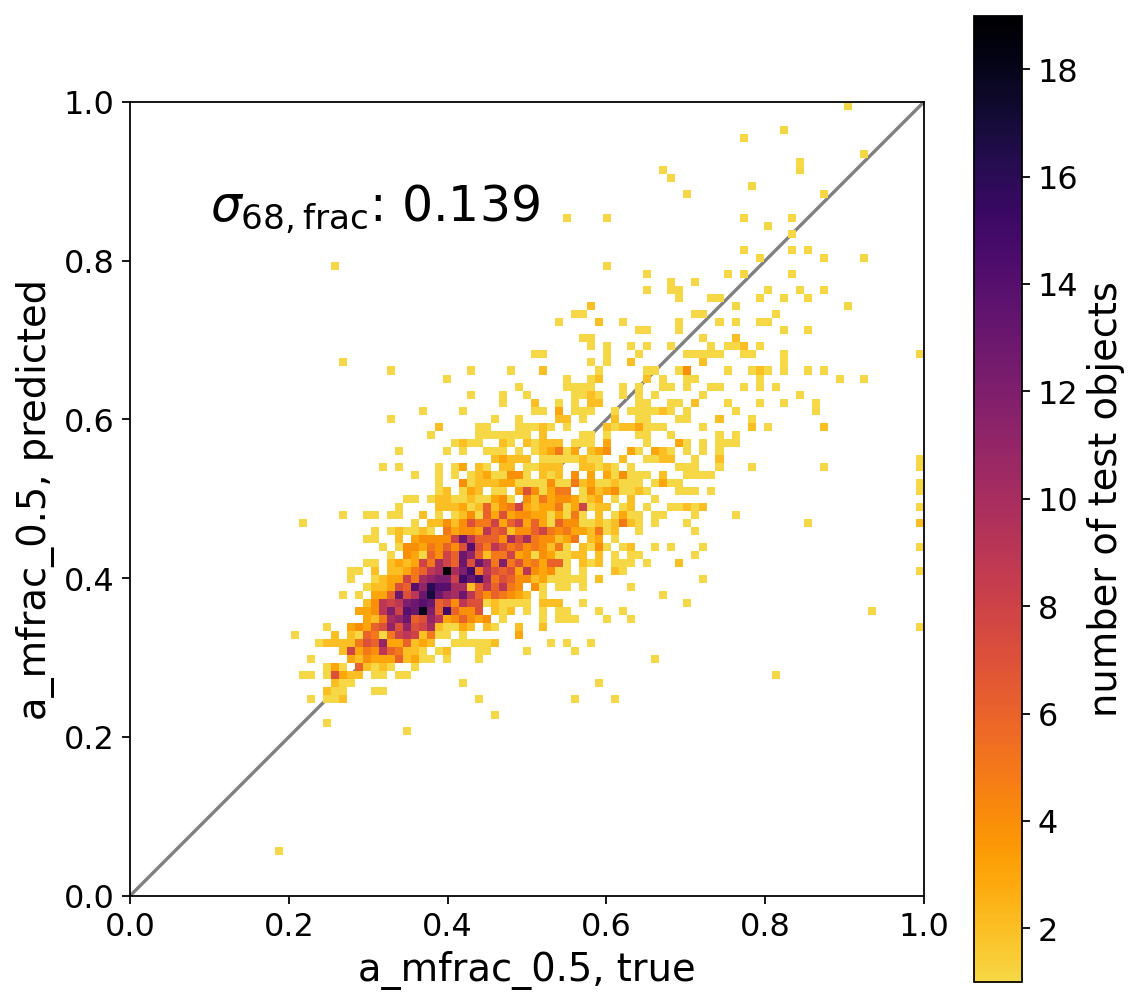

In [63]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile_frac')
error_str = fr"$\sigma_{{68,\mathrm{{frac}}}}$: {error_nn:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(0,1),  y_lim=(0,1))

## multi a_mfrac

In [64]:
y_label_name = 'a_mfrac_n21'

In [257]:
fit_tag = f'_{y_label_name}_nn'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [258]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [259]:
idx_nan = np.isnan(y)
print(np.sum(idx_nan))

0


In [260]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.04545455 0.09090909 0.13636364 0.18181818 0.22727273 0.27272727
 0.31818182 0.36363636 0.40909091 0.45454545 0.5        0.54545455
 0.59090909 0.63636364 0.68181818 0.72727273 0.77272727 0.81818182
 0.86363636 0.90909091 0.95454545]


In [261]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

(0.0, 190.4964874257303)

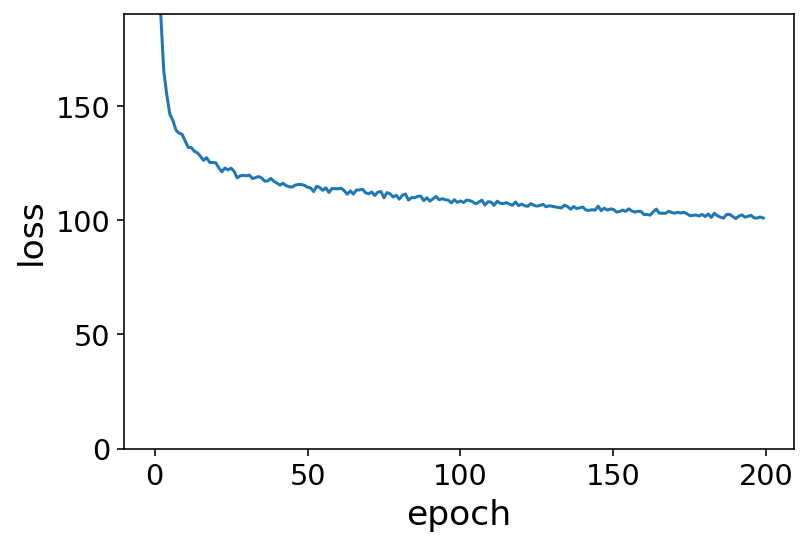

In [262]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, nnfitter.loss[2])

In [263]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

In [264]:
np.random.seed(14)
n_ex = 8
rand_idxs = np.random.randint(len(y_test), size=n_ex)

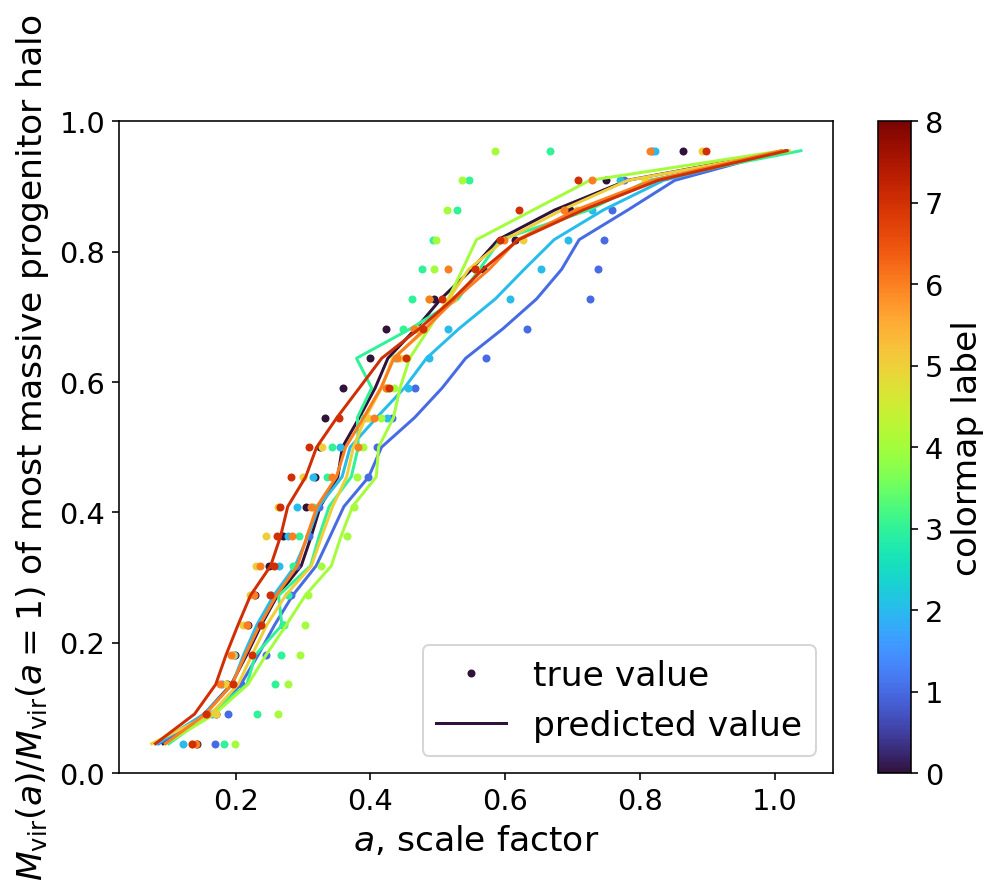

In [265]:
%matplotlib inline
plt.figure(figsize=(8,6))

locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_ex)
cmap = matplotlib.cm.get_cmap('turbo')
colors = [cmap(locs_norm(i)) for i in range(n_ex)]

for i, i_rand in enumerate(rand_idxs):
    halo = sim_reader.dark_halo_arr[i_rand]
    #a_mah, m_mah = halo.catalog_properties['MAH']
    #plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3, ls='None')
    label_true, label_pred = None, None
    if i==0:
        label_true = 'true value'
        label_pred = 'predicted value'

    plt.plot(y_test[i_rand], mfrac_vals, marker='o', markersize=3, ls='None', color=colors[i], label=label_true)
    plt.plot(y_pred[i_rand], mfrac_vals, color=colors[i], label=label_pred)

#plt.yscale('log')
plt.xlabel(r'$a$, scale factor')
plt.ylabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, label='colormap label')
plt.legend()

In [81]:
def plot_a_mfrac_accuracy(a_pred, a_true, mfracs, title='', n_show=8):
    
    locs_norm = matplotlib.colors.Normalize(vmin=0, vmax=n_show)
    cmap = matplotlib.cm.get_cmap('turbo')
    colors = [cmap(locs_norm(i)) for i in range(n_show)]

    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]},
                                  figsize=(6,8))
    plt.subplots_adjust(hspace=0.03)
    fig.suptitle(title, fontsize=16)

    errs = (a_pred - a_true)/a_true

    np.random.seed(14)
    rand_idxs_show = np.random.randint(len(a_true), size=n_show)
    for i, i_rand in enumerate(rand_idxs_show):
        halo = sim_reader.dark_halo_arr[i_rand]
        #a_mah, m_mah = halo.catalog_properties['MAH']
        #plt.plot(a_mah, m_mah/m_mah[0], marker='o', markersize=3, ls='None')

        label_true, label_pred = None, None
        if i==0:
            label_true = 'true value'
            label_pred = 'predicted value'

        ax0.plot(mfracs, a_true[i_rand], marker='o', markersize=4, ls='None', color=colors[i], label=label_true)
        ax0.plot(mfracs, a_pred[i_rand], color=colors[i], label=label_pred)

        ax1.plot(mfracs, errs[i_rand], color=colors[i])

    p16 = np.percentile(errs, 16, axis=0)
    p84 = np.percentile(errs, 84, axis=0)
    sig68_avg = 0.5*(p84-p16)
    ax2.plot(mfracs, p16, color='k', lw=2, label='prediction error')
    ax2.plot(mfracs, p84, color='k', lw=2)
    ax2.axhline(0.0, color='grey', lw=1)

    # print errors
    mfracs_to_print_err = [0.25, 0.5, 0.75]
    errs_to_print = []
    for mfrac in mfracs_to_print_err:
        _, idx_mfrac = utils.find_nearest(mfracs, mfrac)
        errs_to_print.append(rf"$\sigma_{{68}}(M/M_{{a=1}}={mfrac:.2f}) = {sig68_avg[idx_mfrac]:.3f}$")
    
    ax0.text(0.4, 0.1, '\n'.join(errs_to_print), fontsize=14)

    y_test_mean = np.mean(y_test, axis=0)
    sample_var = (y_test - y_test_mean)/y_test_mean
    sample_p16 = np.percentile(sample_var, 16, axis=0)
    sample_p84 = np.percentile(sample_var, 84, axis=0)
    ax2.fill_between(mfracs, sample_p16, sample_p84, color='blue', lw=2, alpha=0.3, label='sample variance')

    ax0.set_ylabel(r'$a$, scale factor')
    ax1.set_ylabel(r'$(a_\mathrm{pred}-a_\mathrm{true})/a_\mathrm{true}$')
    ax2.set_ylabel(r'$\sigma_{68}$')

    ax2.set_xlabel(r'$M_\mathrm{vir}(a)$/$M_\mathrm{vir}(a=1)$ of most massive progenitor halo')

    ax0.set_ylim(0,1)
    ax1.axhline(0.0, color='grey', lw=1)

    ax0.legend(fontsize=14, loc='upper left')
    ax2.legend(fontsize=14)

In [277]:
error, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
print(error)

[0.03612292 0.03273374 0.03711058 0.04074182 0.04406585 0.0474981
 0.05275816 0.05517443 0.05907459 0.06110103 0.06554398 0.06783832
 0.06869006 0.06926685 0.07092846 0.07298388 0.07467133 0.07765788
 0.08428676 0.08837217 0.10606411]


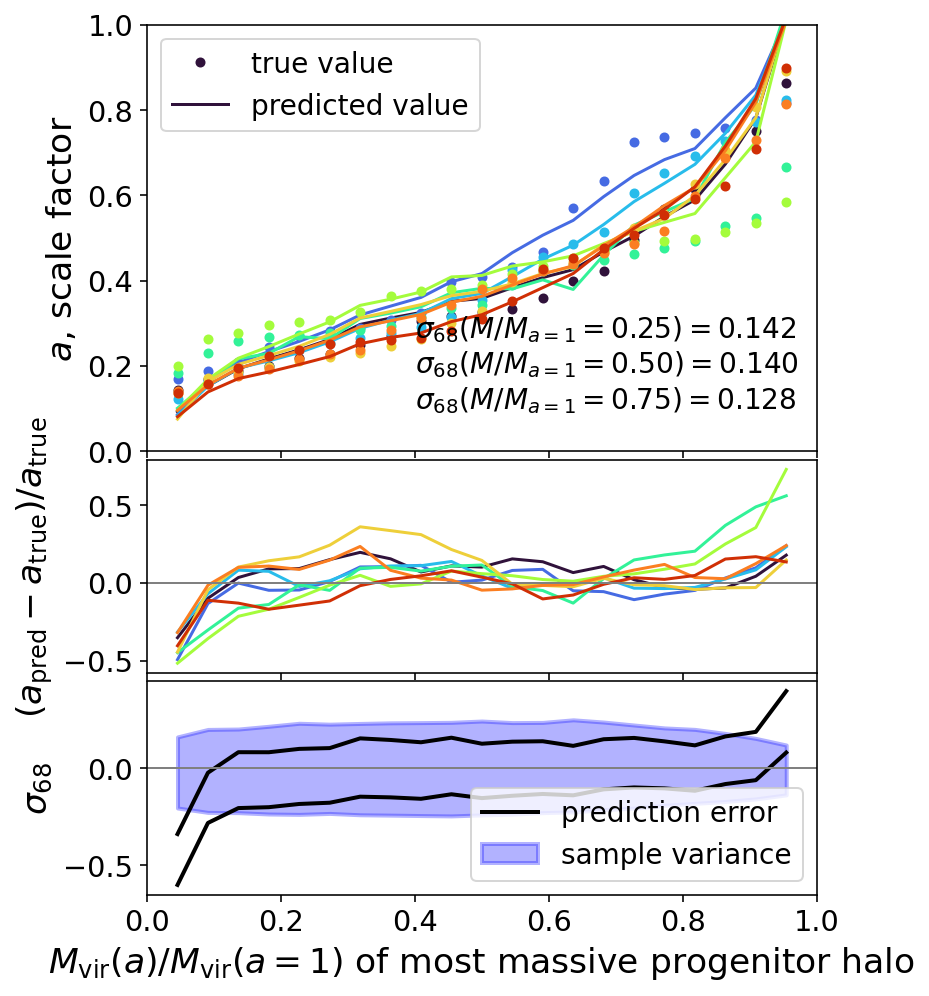

In [278]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='')

10.417615 14.303833


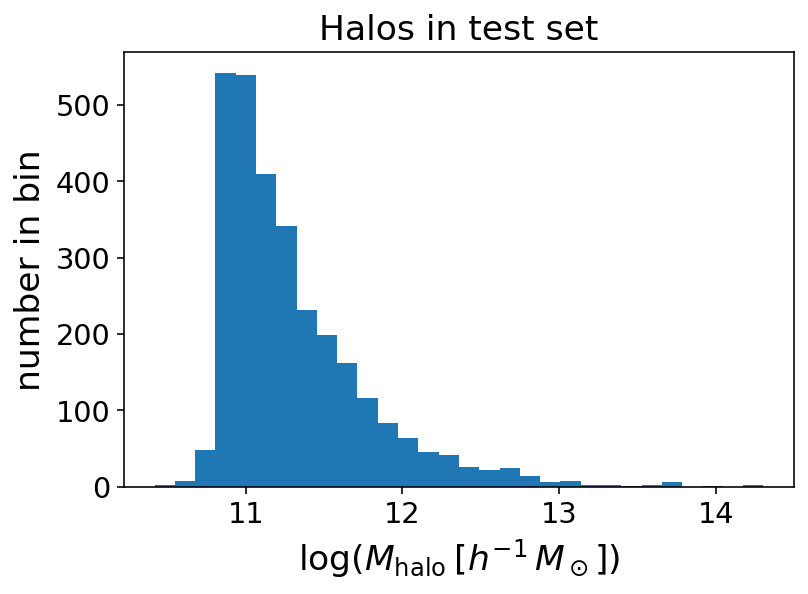

In [125]:
plt.title('Halos in test set')
plt.hist(log_m_200m[idx_test]+log_mass_shift, bins=30)
plt.xlabel(utils.label_dict['m_200m'])
plt.ylabel('number in bin')
print(np.min(log_m_200m[idx_test]+log_mass_shift), np.max(log_m_200m[idx_test]+log_mass_shift))

Uhh i thought that 10.8 was our min halo mass... TODO investigate!! 

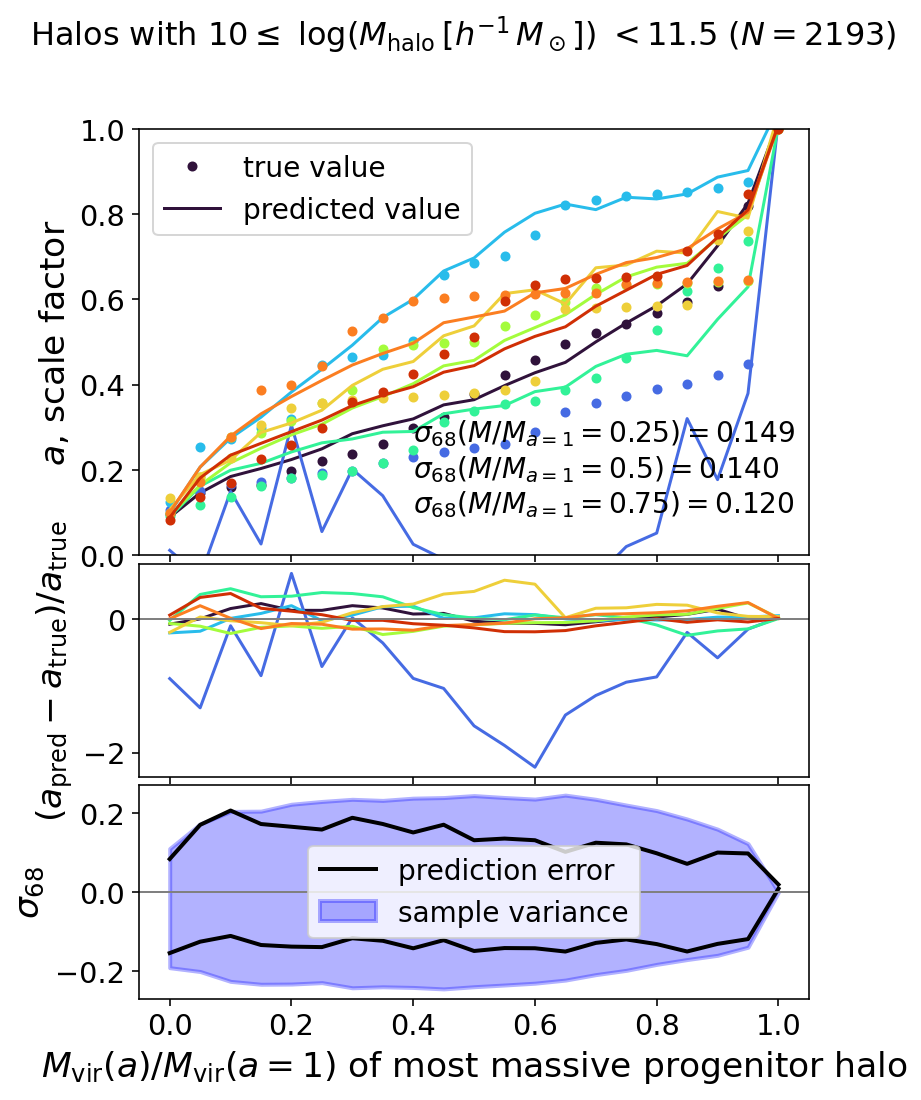

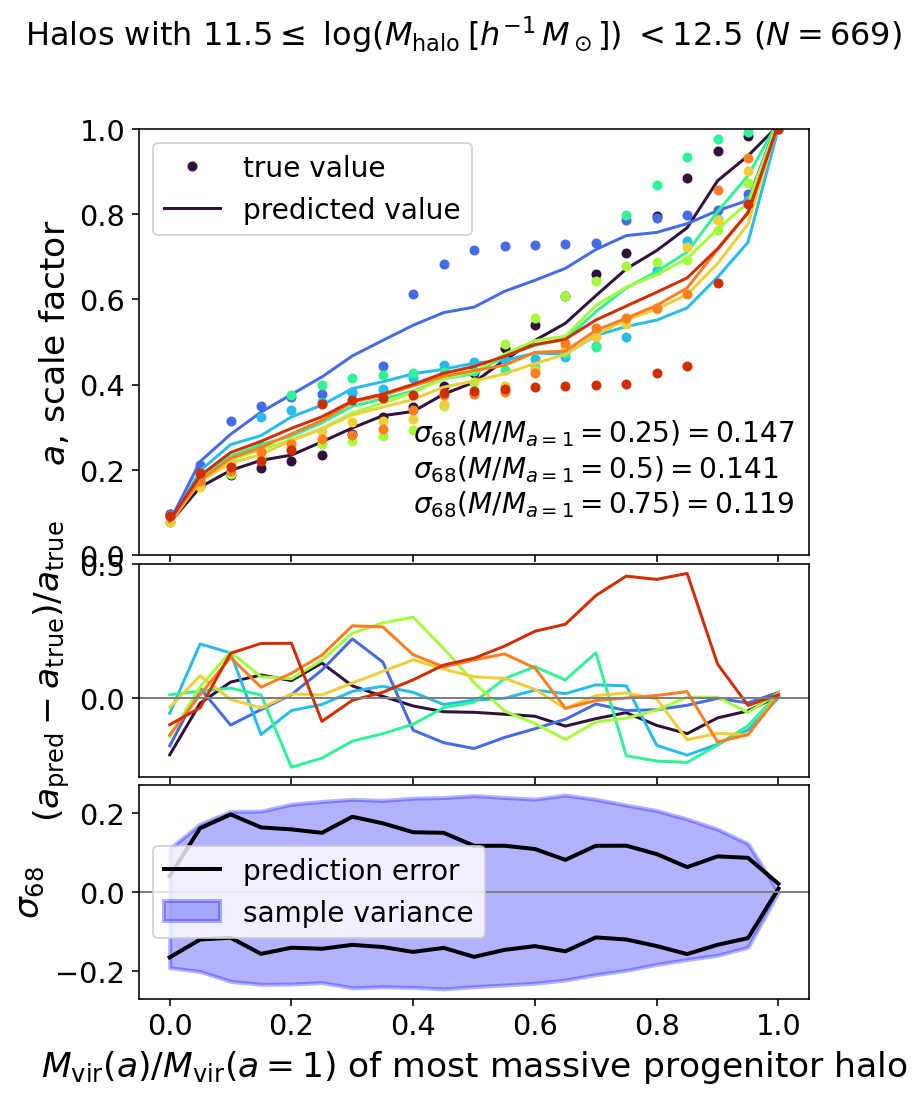

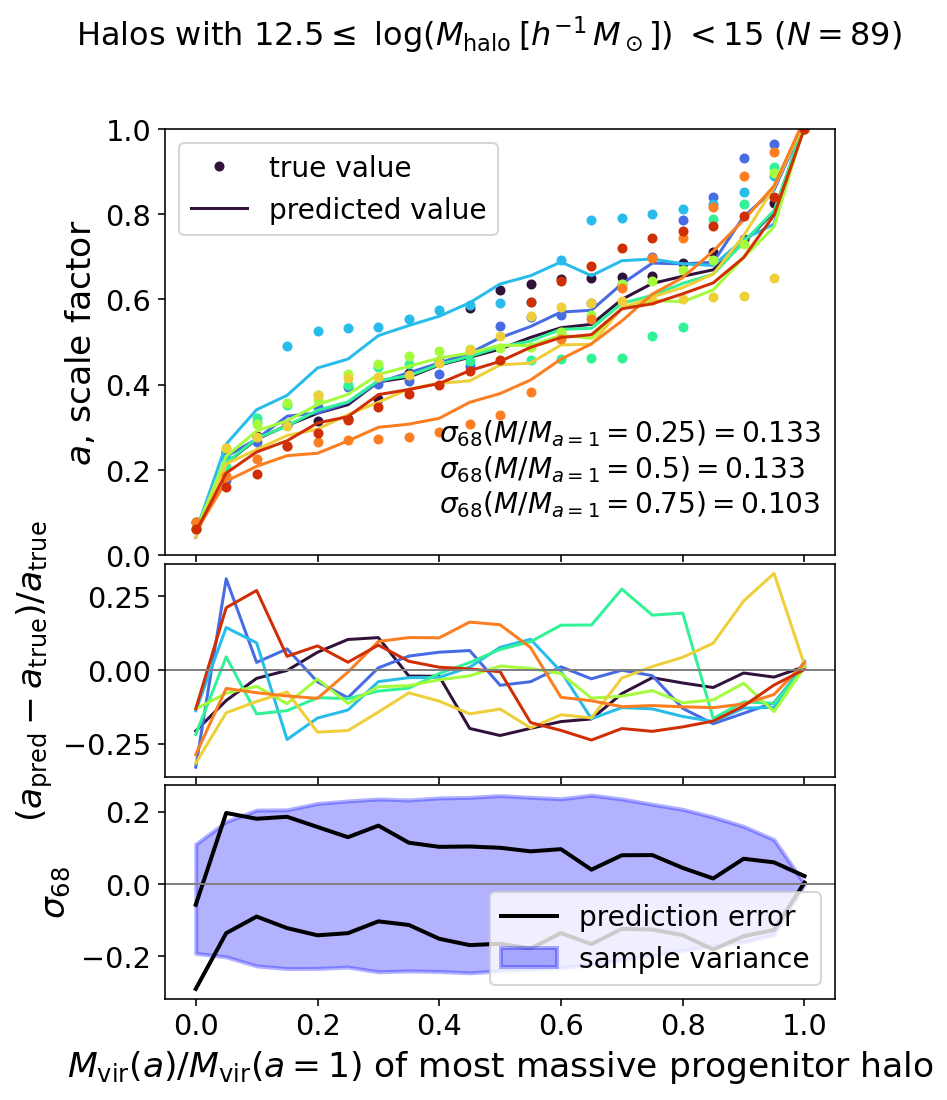

In [128]:
%matplotlib inline

m200m_bins = [10, 11.5, 12.5, 15]
logms_test = log_m_200m[idx_test]+log_mass_shift

for i in range(len(m200m_bins)-1):
    idx_test_inbin = (logms >= m200m_bins[i]) & (logms < m200m_bins[i+1])
    n = np.sum(idx_test_inbin)
    title = rf"Halos with ${m200m_bins[i]} \leq$ {utils.label_dict['m_200m']} $< {m200m_bins[i+1]}$ $(N={n})$"
    plot_a_mfrac_accuracy(y_pred[idx_test_inbin], y_test[idx_test_inbin], mfrac_vals, title=title)

(-0.5, 0.5)

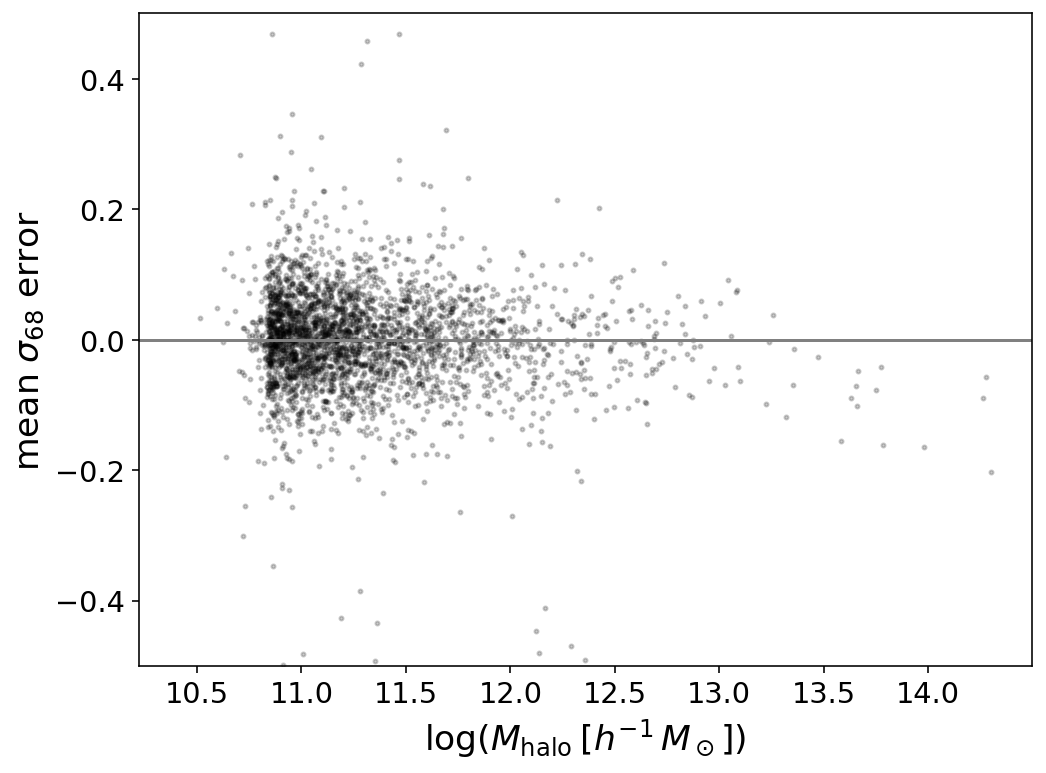

In [129]:
errs = (y_pred - y_test)/y_test
mean_errs = np.mean(errs, axis=1)

plt.figure(figsize=(8,6))
plt.scatter(logms_test, mean_errs, color='k', s=4, alpha=0.2)
plt.axhline(0.0, color='grey')
plt.xlabel(utils.label_dict['m_200m'])
plt.ylabel(r'mean $\sigma_{68}$ error')
plt.ylim(-0.5, 0.5)


# mfrac w fewer points

## multi a_mfrac

In [129]:
y_label_name = 'a_mfrac_n3'

In [130]:
#fit_tag = f'_{y_label_name}_nn'
fit_tag = f'_{y_label_name}_nn_epochs2500'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [131]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [132]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.25 0.5  0.75]


In [133]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

Text(0, 0.5, 'loss')

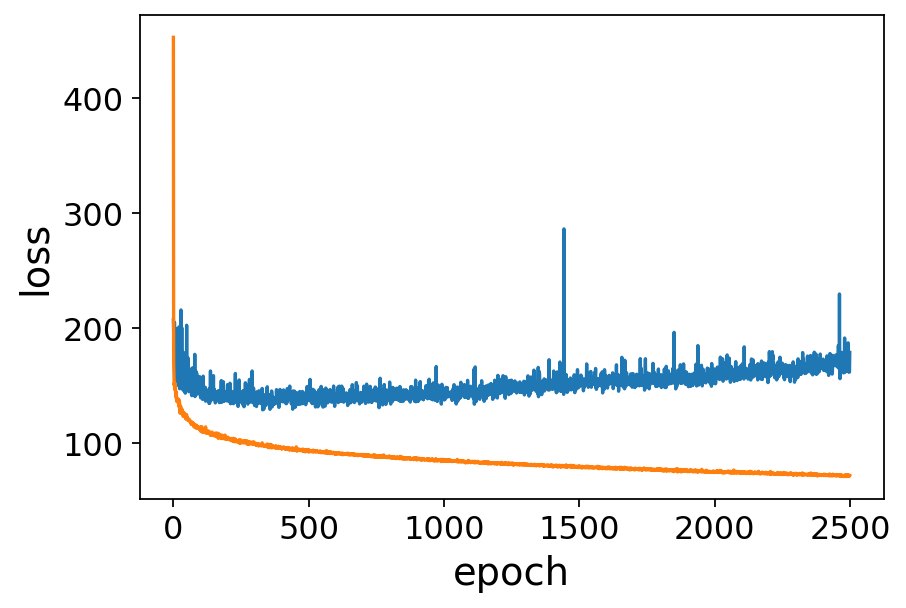

In [140]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
#print(np.min(nnfitter.loss))

In [136]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

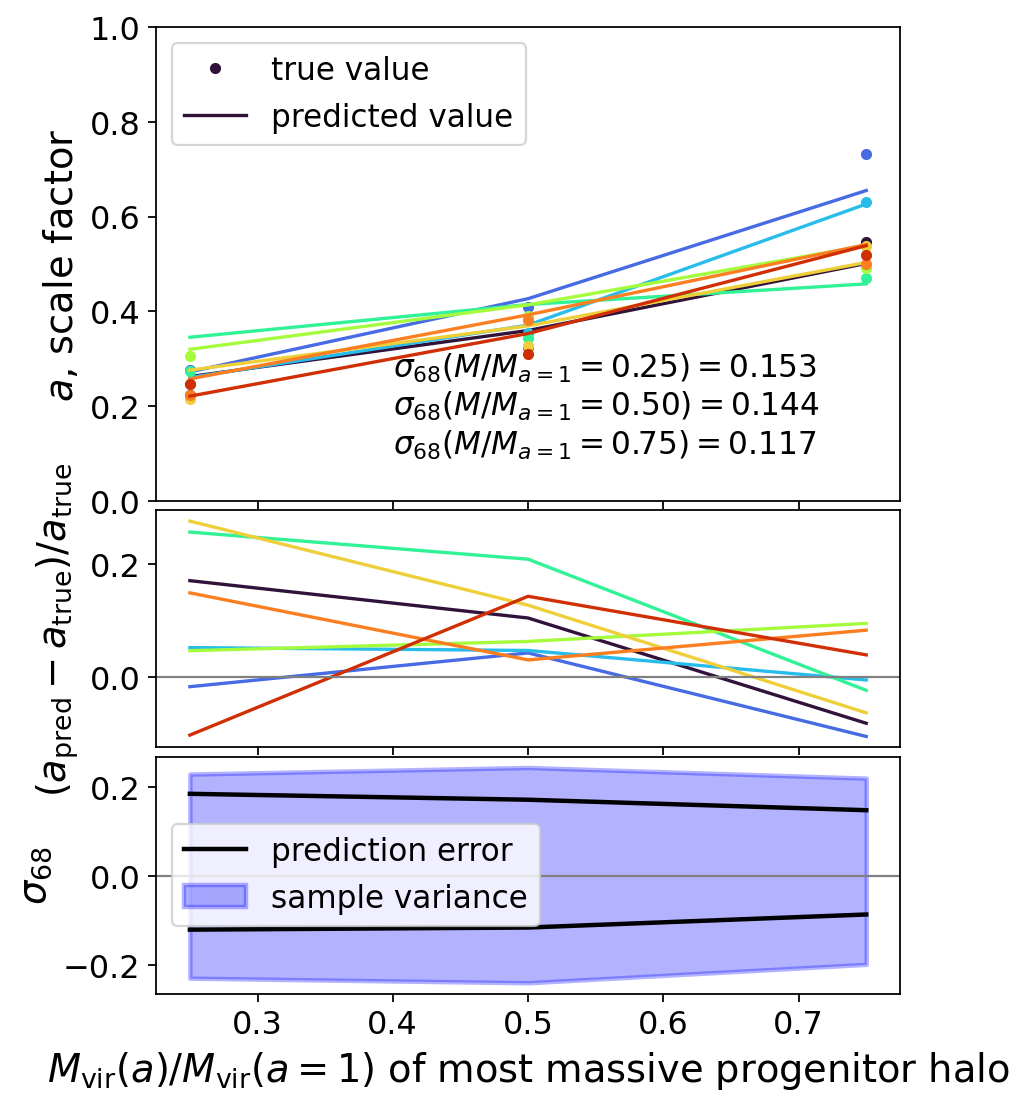

In [137]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

## multi a_mfrac

In [121]:
y_label_name = 'a_mfrac_n7'

In [122]:
#fit_tag = f'_{y_label_name}_nn'
fit_tag = f'_{y_label_name}_nn_epochs2000'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [123]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [124]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.125 0.25  0.375 0.5   0.625 0.75  0.875]


In [125]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

79.09826313830736


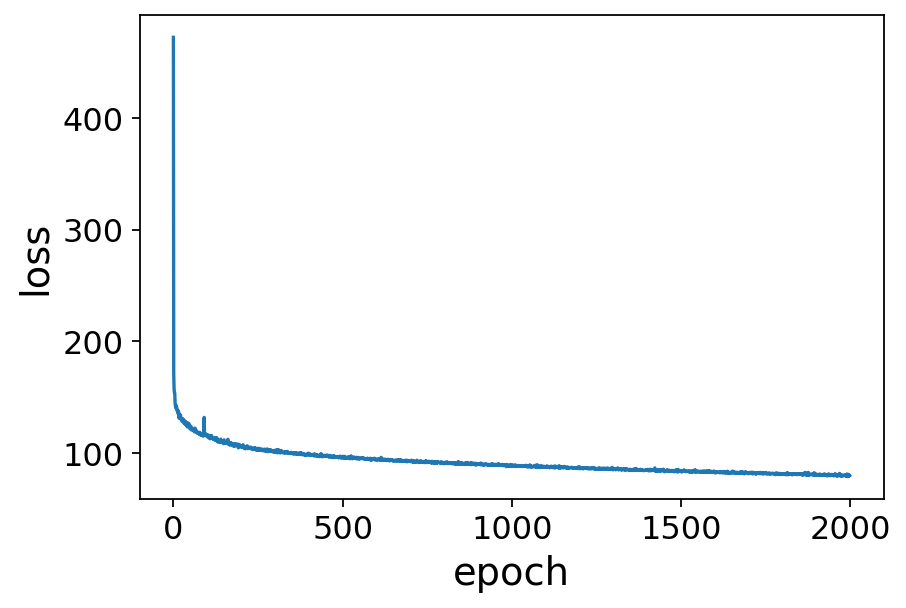

In [126]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
print(np.min(nnfitter.loss))

In [127]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

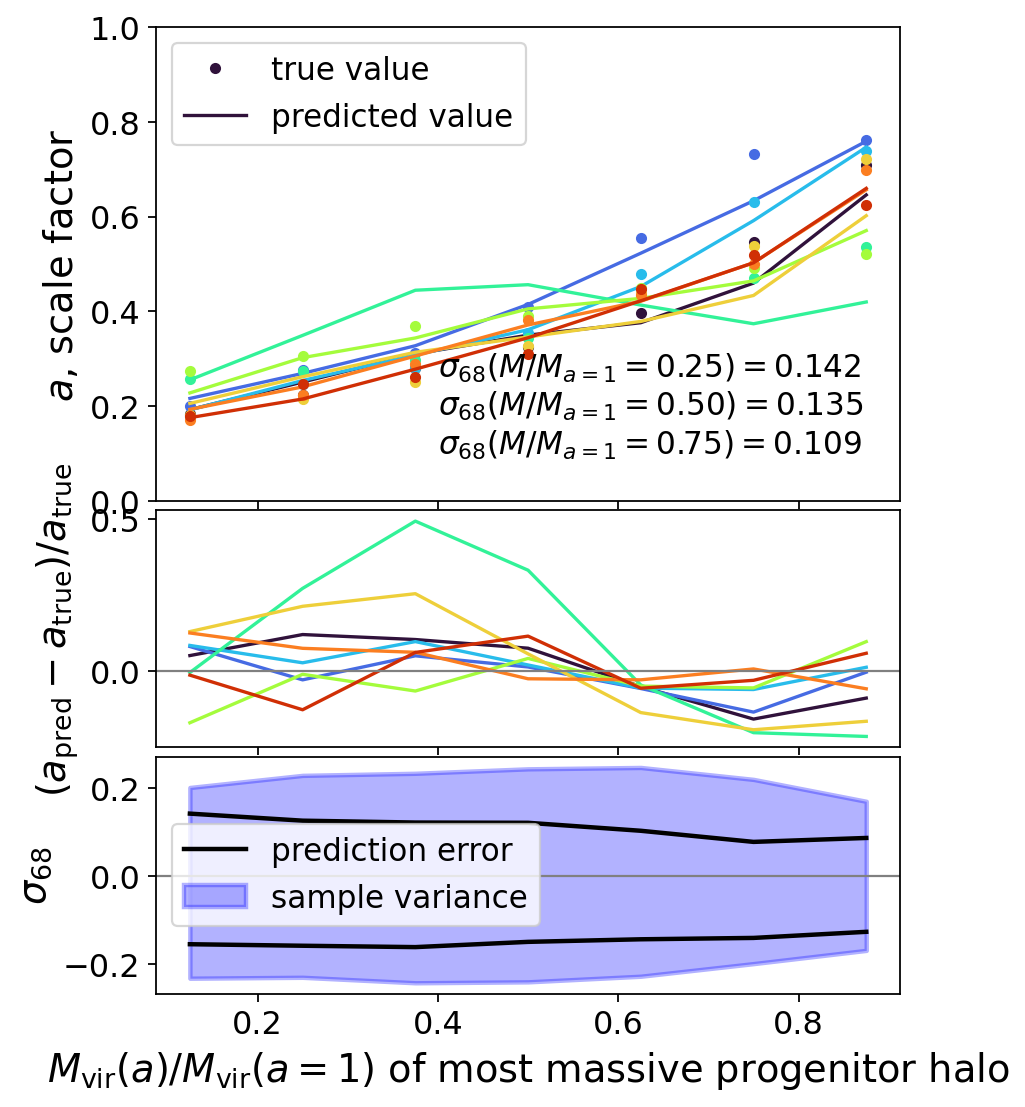

In [128]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

## multi a_mfrac

In [100]:
y_label_name = 'a_mfrac_n19'

In [101]:
#fit_tag = f'_{y_label_name}_nn'
fit_tag = f'_{y_label_name}_nn_epochs2500'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [102]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [103]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


In [104]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

132.34264831802184


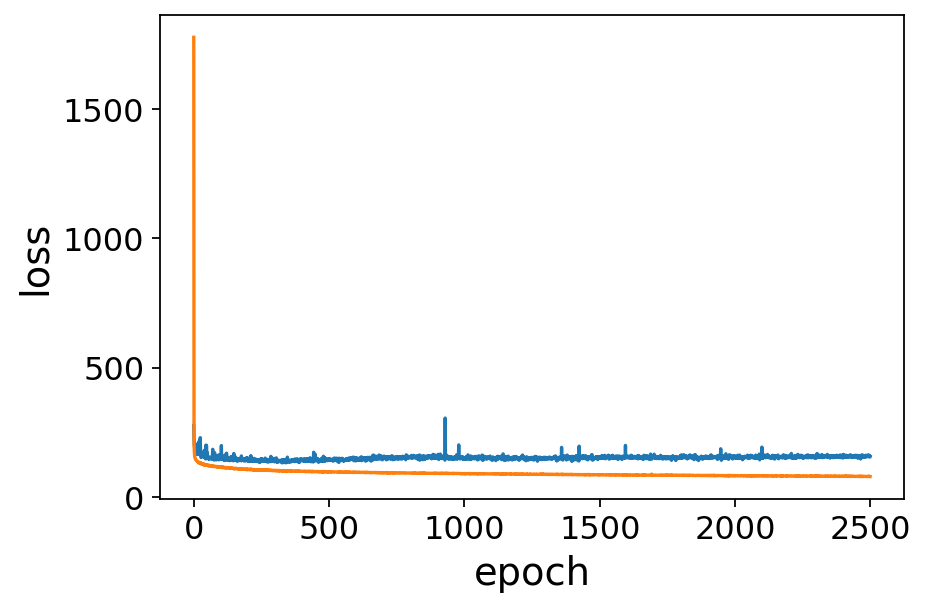

In [105]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
print(np.min(nnfitter.loss_valid))

In [106]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

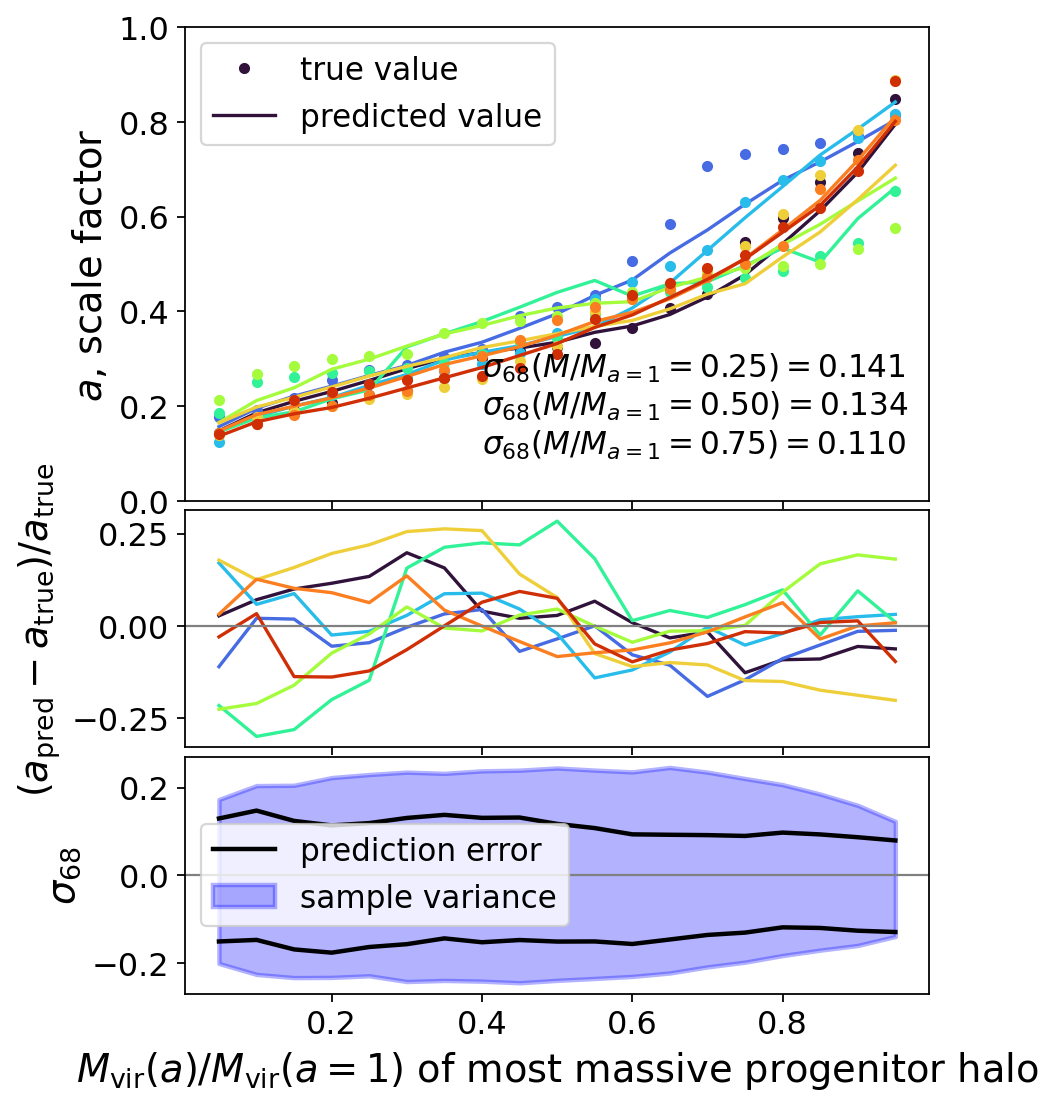

In [107]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

# n39

In [108]:
y_label_name = 'a_mfrac_n39'

In [109]:
#fit_tag = f'_{y_label_name}_nn'
fit_tag = f'_{y_label_name}_nn_epochs2500'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [110]:
y = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
y_test = y[idx_test]

In [111]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3
 0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575 0.6
 0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875 0.9
 0.925 0.95  0.975]


In [112]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

127.94662279678877


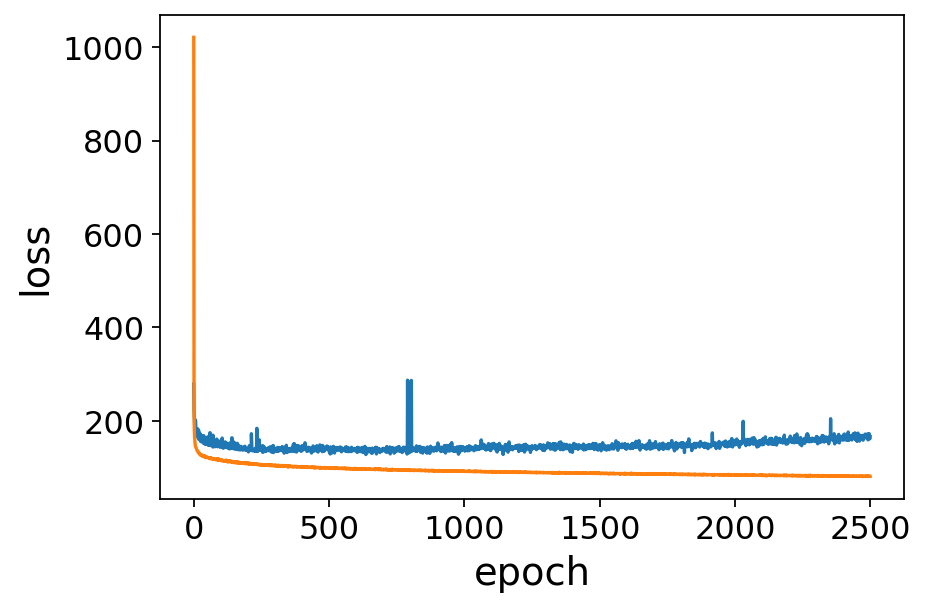

In [113]:
plt.plot(nnfitter.loss_valid)
plt.plot(nnfitter.loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0, nnfitter.loss[2])
print(np.min(nnfitter.loss_valid))

In [114]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

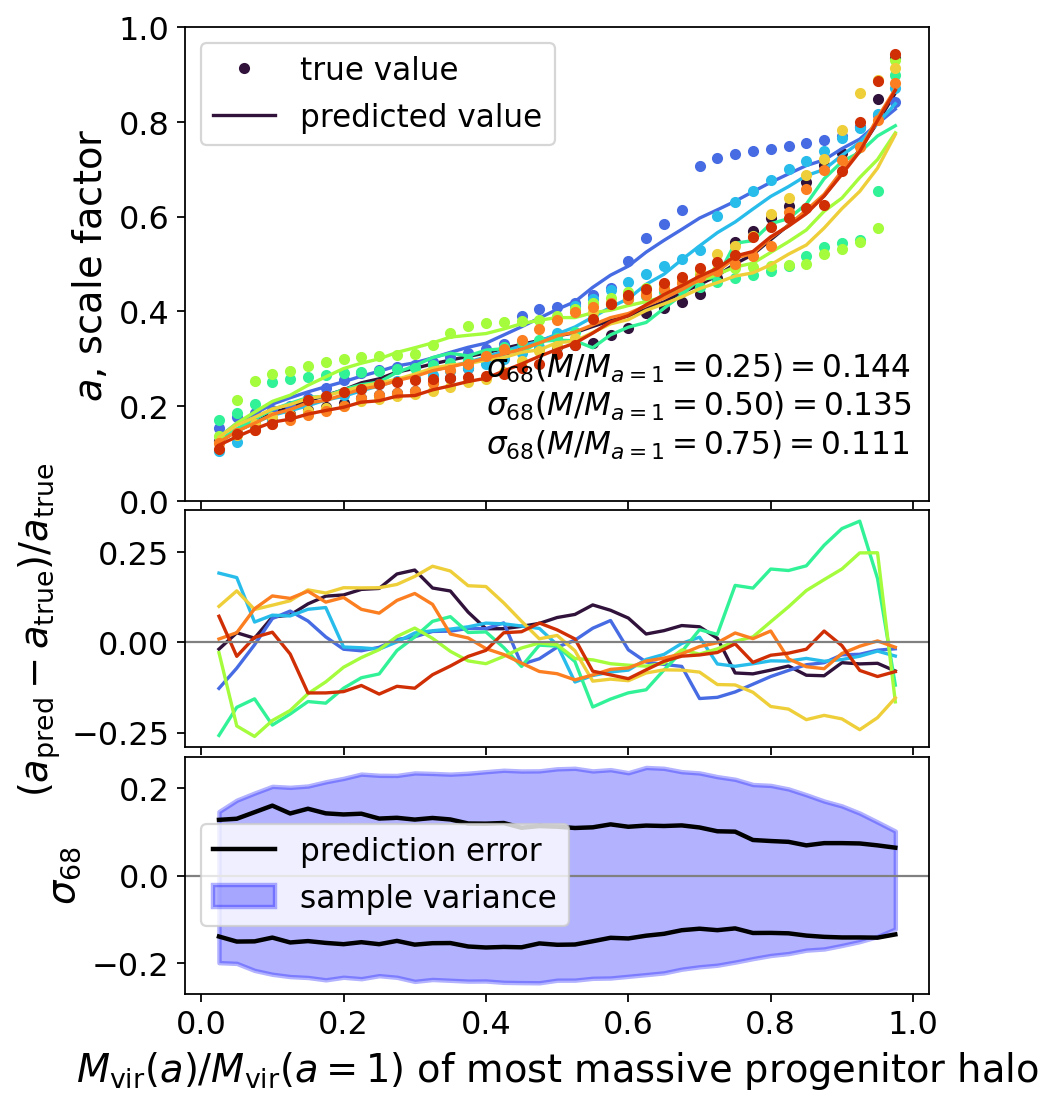

In [115]:
plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

# mfracs single together

In [ ]:
mfrac_vals = [0.75]

In [148]:
y = []
for mfrac in mfrac_vals:
    y_label_name = 'a_mfrac_{mfrac}'
    fit_tag = f'_{y_label_name}_nn'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'
    y_single = utils.get_y_vals(y_label_name, sim_reader, halo_tag=halo_tag)
    y.append(y_single)

y = np.array(y).T
print(y.shape)

In [ ]:
y_test = y[]

In [ ]:
y_pred = []
for mfrac in mfrac_vals:
    
    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)
    y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)
    

y = np.array(y).T
print(y.shape)

In [151]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does
print(mfrac_vals)

[0.25 0.5  0.75]
